In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

import statsmodels.api as sm
import ast
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import resample
import seaborn as sns
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

rd = pd.read_excel('./Resources/combined_phecodex_list.xlsx')
cd = rd.loc[rd['Type'] == 'Common']

def cb(series):
    return series.apply(lambda x: 1 if x > 0 else 0)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Optional plotting function
if True:
    import os
    import matplotlib
    import matplotlib.font_manager as font_manager

    font_path = '/sc/arion/projects/GENECAD/Robert/arial.ttf'
    assert os.path.exists(font_path)
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    matplotlib.rc('font', family='sans-serif')
    matplotlib.rcParams.update({
        'font.size': 12,
        'font.sans-serif': prop.get_name(),
        'axes.titlesize': 12
    })

def bootstrap_ci_parallel_joblib(y_true, y_pred, n_bootstraps=1000, alpha=0.05, seed=42, n_jobs=-1):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    n = y_true.shape[0]

    def _one(i):
        rng = np.random.default_rng(seed + i)
        idx = rng.integers(0, n, size=n, endpoint=False)
        yt = y_true[idx]; yp = y_pred[idx]
        if yt.min() == yt.max():
            return None
        return float(roc_auc_score(yt, yp)), float(average_precision_score(yt, yp))

    res = Parallel(n_jobs=n_jobs, backend="loky", prefer="processes")(
        delayed(_one)(i) for i in range(n_bootstraps)
    )
    aurocs = [a for a in (r[0] if r else None for r in res) if a is not None]
    auprcs = [p for p in (r[1] if r else None for r in res) if p is not None]

    def _ci(arr):
        arr = np.asarray(arr)
        return (float(np.percentile(arr, 2.5)),
                float(np.mean(arr)),
                float(np.percentile(arr, 97.5)))

    return {'auroc': _ci(aurocs), 'auprc': _ci(auprcs)}

In [3]:
alldata = pd.read_pickle('./Final/ml_input.pkl')

alldata['xscore'] = 0.0
alldata.loc[alldata['phase'] == 0.5, 'xscore'] = 1*0.732*0.548*0.580*0.911
alldata.loc[alldata['phase'] == 1, 'xscore'] = 1*0.732*0.548*0.580
alldata.loc[alldata['phase'] == 2, 'xscore'] = 1*0.732*0.548
alldata.loc[alldata['phase'] == 3, 'xscore'] = 1*0.732
alldata.loc[alldata['phase'] == 4, 'xscore'] = 1

indata = alldata.loc[alldata['drug_gene'] == 1]

ind = indata.groupby('phecode')['indication'].max().reset_index()
ind = ind.loc[ind['indication'] == 1]
indata = indata.loc[indata['phecode'].isin(ind['phecode'])]
print(indata['phecode'].nunique())

#####

clin = ['clingen','eva','gene2phenotype','genomics_england','orphanet','uniprot_literature', 'uniprot_variants']
ot = ['clin_ot','hgmd','gwas_credible_sets','expression_atlas','impc','europepmc']
mantis = ['mantis']
cc = ['cc_common_max_p','cc_rare_max_p','cc_rare_burden_max_p','cc_ultrarare_max_p']


112


In [4]:
# Get dataset size and number indicated
cond = 'ot_mantis_cc'
df = pd.read_pickle(f'./GPS/Main/Predictions/holdout_predictions_{cond}.pkl')
print(len(df), df['indication'].sum())

356272 5912


In [5]:
# Run bootstrap for metrics
conds = ['ot','mantis','cc','ot_mantis','ot_mantis_cc']

results = []
for cond in conds:
    print('Holdout',cond)
    pdf = pd.read_pickle(f'./GPS/Main/Predictions/holdout_predictions_{cond}.pkl').reset_index(drop=True)
    auroc = roc_auc_score(pdf['indication'], pdf['prediction'])
    auprc = average_precision_score(pdf['indication'], pdf['prediction'])
    ci = bootstrap_ci_parallel_joblib(pdf['indication'], pdf['prediction'])
    results.append({'Dataset':'Holdout','Features':cond,
                    'AUROC':auroc, 'AUROC_CI': ci['auroc'],
                    'AUPRC':auprc, 'AUPRC_CI': ci['auprc']})
res_df = pd.DataFrame(results)
res_df.to_excel('./Results/bootstrap_metrics_holdout.xlsx', index=False)


Holdout ot
Holdout mantis
Holdout cc
Holdout ot_mantis
Holdout ot_mantis_cc


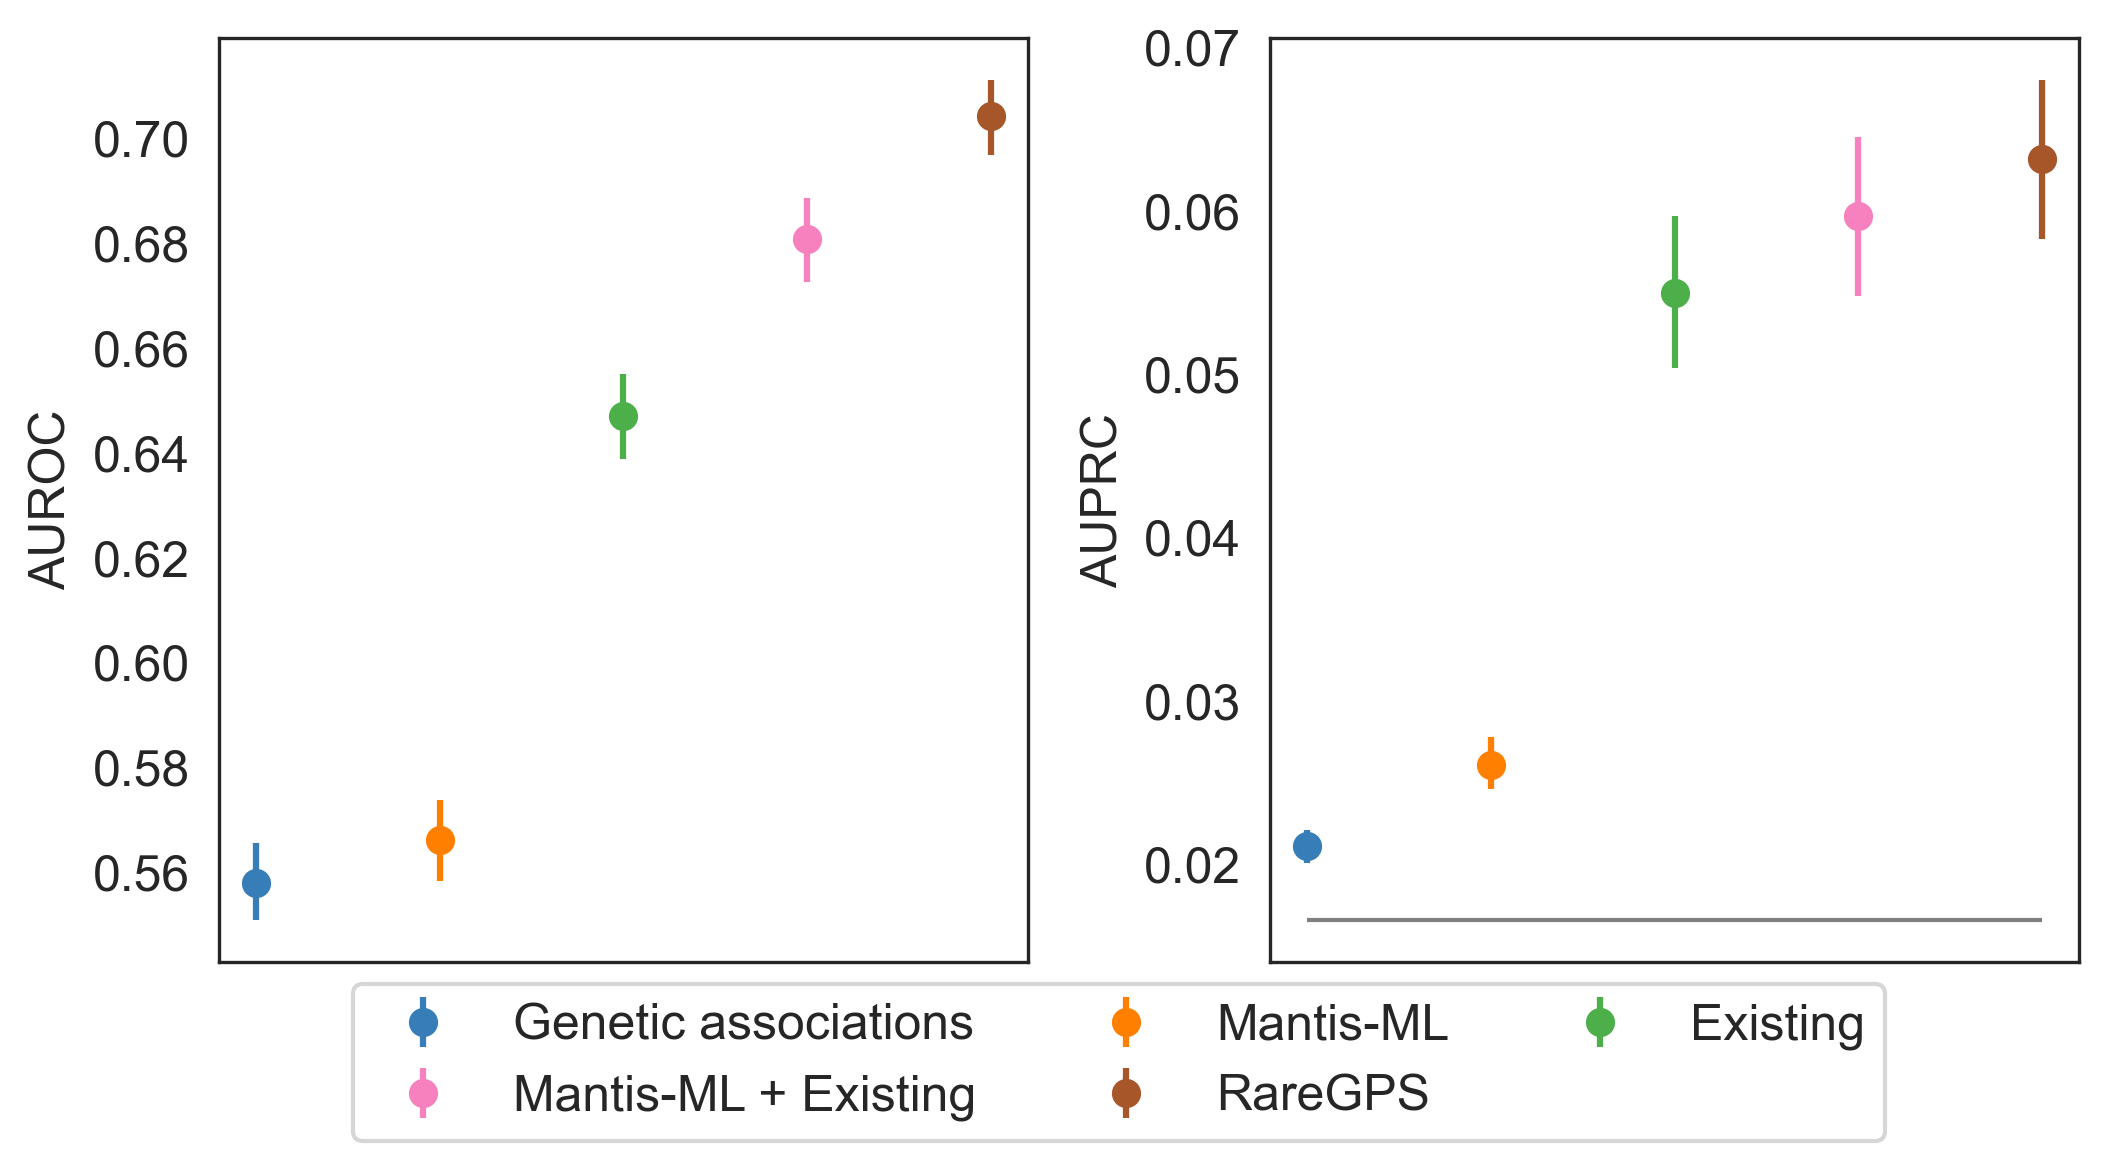

In [30]:
# Generate plots
metrics = pd.read_excel('./Results/bootstrap_metrics_holdout.xlsx')
metrics['Model'] = metrics['Features'].map({'ot':'Existing',
                                             'mantis':'Mantis-ML','cc':'Genetic associations',
                                             'ot_mantis':'Mantis-ML + Existing',
                                             'ot_mantis_cc':'RareGPS'})
desired_order = ['Genetic associations','Mantis-ML','Existing','Mantis-ML + Existing','RareGPS']

# Data prep (AUROC)
auroc_df = metrics.copy()
auroc_df['Model'] = pd.Categorical(auroc_df['Model'],desired_order,ordered=True)
auroc_df = auroc_df.sort_values(['Dataset','Model'])

auroc_df['AUROC_mean'] = auroc_df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)[1]).astype(float)
auroc_df['AUROC_CI_lower'] = auroc_df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)[0]).astype(float)
auroc_df['AUROC_CI_upper'] = auroc_df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)[2]).astype(float)
auroc_df['error_lower'] = auroc_df['AUROC_mean'] - auroc_df['AUROC_CI_lower']
auroc_df['error_upper'] = auroc_df['AUROC_CI_upper'] - auroc_df['AUROC_mean']

# Data prep (AUPRC)
# Baseline proportion for horizontal reference lines
hold_prop = pd.read_pickle('./GPS/Main/Predictions/holdout_predictions_ot.pkl')['indication'].mean()

auprc_df = metrics.loc[~metrics['Features'].isin(['cov_otnopmc','cov_otnopmc_cc'])].copy()
auprc_df['Model'] = pd.Categorical(auprc_df['Model'],desired_order,ordered=True)
auprc_df['Proportion'] = auprc_df['Dataset'].map({'Holdout': hold_prop})
auprc_df = auprc_df.sort_values(['Dataset','Model'])

auprc_df['AUPRC_mean'] = auprc_df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)[1]).astype(float)
auprc_df['AUPRC_CI_lower'] = auprc_df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)[0]).astype(float)
auprc_df['AUPRC_CI_upper'] = auprc_df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)[2]).astype(float)
auprc_df['error_lower'] = auprc_df['AUPRC_mean'] - auprc_df['AUPRC_CI_lower']
auprc_df['error_upper'] = auprc_df['AUPRC_CI_upper'] - auprc_df['AUPRC_mean']

# Figure with two subplots
sns.set_style('white')
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=300, constrained_layout=False)
fig.subplots_adjust(wspace=0.3)
models = list(auroc_df['Model'].cat.categories)
width = 0.175

# -------- Left panel: AUROC --------
ax = axes[0]
datasets = auroc_df['Dataset'].unique()
x = np.arange(len(datasets))

for i, model in enumerate(models):
    md = auroc_df[auroc_df['Model'] == model].sort_values('Dataset')
    ax.errorbar(
        x + (i - (len(models) - 1)/2) * width,
        md['AUROC_mean'],
        yerr=[md['error_lower'], md['error_upper']],
        fmt='o', capsize=0, label=str(model), color=CB_color_cycle[i % len(CB_color_cycle)]
    )

ax.set_xticks(x, datasets)
ax.set_xticklabels([])
ax.set_ylabel('AUROC')
ax.set_xlabel('')

# -------- Right panel: AUPRC --------
ax = axes[1]
datasets2 = auprc_df['Dataset'].unique()
x2 = np.arange(len(datasets2))

for i, model in enumerate(models):
    md = auprc_df[auprc_df['Model'] == model].sort_values('Dataset')
    ax.errorbar(
        x2 + (i - (len(models) - 1)/2) * width,
        md['AUPRC_mean'],
        yerr=[md['error_lower'], md['error_upper']],
        fmt='o', capsize=0, label=str(model), color=CB_color_cycle[i % len(CB_color_cycle)]
    )

# Horizontal baseline(s) per dataset (e.g., class prevalence on holdout)
for i, dset in enumerate(datasets2):
    prop = auprc_df.loc[auprc_df['Dataset'] == dset, 'Proportion'].iloc[0]
    if pd.notnull(prop):
        left = x2[i] - (len(models) - 1)/2 * width
        right = x2[i] + (len(models) - 1)/2 * width
        ax.hlines(y=prop, xmin=left, xmax=right, color='gray', linestyle='-', linewidth=1)

ax.set_xticks(x2, datasets2)
ax.set_xticklabels([])
ax.set_ylabel('AUPRC')

# -------- Single legend below (row-wise visual order) --------
handles, labels = axes[0].get_legend_handles_labels()
label_to_handle = dict(zip(labels, handles))
handles_ord = [label_to_handle[l] for l in desired_order]
labels_ord  = desired_order

ncol = 3
n = len(labels_ord)
nrows = int(np.ceil(n / ncol))
perm = np.arange(nrows * ncol).reshape(nrows, ncol).ravel(order='F')
perm = perm[perm < n]

fig.legend([handles_ord[i] for i in perm],
           [labels_ord[i]  for i in perm],
           loc='lower center', ncol=ncol,
           bbox_to_anchor=(0.5, -0.06))

plt.show()